 # <center> Music Recommendation System 
 

## Installing Requried Libraries

In [ ]:
pip install fuzzywuzzy

In [ ]:
pip install python-Levenshtein

In [ ]:
pip install scikit-surprise

## Importing Requried Libraries

In [ ]:
#To Store And Retrive Data
from google.colab import drive
import os

#For Data Processing
import numpy as np
import pandas as pd

#For Content Based Filtering 
from typing import List, Dict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#For Collabarative Filtering -KNN
import random
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz

#For Matrix Factorization-SVD
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

#For Visulizations
import matplotlib.pyplot as plt
import seaborn as sns

#To Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
triplet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Million Song Dataset/kaggle_visible_evaluation_triplets.txt' , sep='\t',names=['user_id','song_id','listen_count'])
tracks = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Million Song Dataset/unique_tracks.txt',sep='<SEP>',names=['track_id','song_id','artist_name','release'])

In [ ]:
df = pd.merge(triplet, tracks.drop_duplicates(['song_id']), on="song_id", how="left")

## Popularity Based Recommendation System

- **As the name suggests Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.**

- **The problems with popularity based recommendation system is that the personalization is not available with this method i.e. even though you know the behaviour of the user you cannot recommend items accordingly**

In [ ]:
song_df = df.copy()

In [ ]:
song_df['song']=song_df['artist_name']+ '-' + song_df['release']

In [ ]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1]).head(10)

,song,listen_count,percentage
59878,Harmonia-Sehr kosmisch,5043,0.347570
17175,Björk-Undo,4483,0.308974
42714,Dwight Yoakam-You're The One,4136,0.285058
51326,Florence + The Machine-Dog Days Are Over (Radi...,3780,0.260522
77664,Kings Of Leon-Revelry,3672,0.253079
104295,OneRepublic-Secrets,3430,0.236400
13348,Barry Tuckwell/Academy of St Martin-in-the-Fie...,3272,0.225510
151720,Train-Hey_ Soul Sister,2791,0.192359
27290,Charttraxx Karaoke-Fireflies,2725,0.187810
25696,Cartola-Tive Sim,2668,0.183882


In [ ]:
#@title
# Class For Popularity Recommendation
class popularity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        return user_recommendations

In [ ]:
pm = popularity_recommender_py() #Creating Instance of class
pm.create(song_df , 'user_id', 'song')

In [ ]:
users = song_df['user_id'].unique()

In [ ]:
#use the popularity model to make some prediction
user_id = users[7]
pm.recommend(user_id)

,user_id,song,score,Rank
59878,c34670d9c1718361feb93068a853cead3c95b76a,Harmonia-Sehr kosmisch,5043,1.0
17175,c34670d9c1718361feb93068a853cead3c95b76a,Björk-Undo,4483,2.0
42714,c34670d9c1718361feb93068a853cead3c95b76a,Dwight Yoakam-You're The One,4136,3.0
51326,c34670d9c1718361feb93068a853cead3c95b76a,Florence + The Machine-Dog Days Are Over (Radi...,3780,4.0
77664,c34670d9c1718361feb93068a853cead3c95b76a,Kings Of Leon-Revelry,3672,5.0
104295,c34670d9c1718361feb93068a853cead3c95b76a,OneRepublic-Secrets,3430,6.0
13348,c34670d9c1718361feb93068a853cead3c95b76a,Barry Tuckwell/Academy of St Martin-in-the-Fie...,3272,7.0
151720,c34670d9c1718361feb93068a853cead3c95b76a,Train-Hey_ Soul Sister,2791,8.0
27290,c34670d9c1718361feb93068a853cead3c95b76a,Charttraxx Karaoke-Fireflies,2725,9.0
25696,c34670d9c1718361feb93068a853cead3c95b76a,Cartola-Tive Sim,2668,10.0


## Content-based Filtering

**Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.**

**Simply put, if the users has listened to New Orleans Blue-Jazz Songs in the past, say of artist Jackson C.Frank, you will be recommend a new artist like Louis Armstrong or Allen Toussiant.**
$$ \\ $$

**Keyword Matching** :

A process of matching or extracting meaningful keyword present in a song description a user liked,  search for the same or similar in other songs descriptions to estimate similarities among them and then based on the similarity, recommend a song to user.
    
**Two step approach :**
    
<li>Extract features out of content and create an object representation
<li>Define a similarity function among these representations.
$$ \\ $$    

**Step - 1 : TF-IDF**
    
 - A technique used for information retrieval. It weighs a term's frequency(TF) and it's inverse document frequency(IDF). 
 - Simply put, count each keywords occurance in document and finding it's importance by calculating TF-IDF score.

$$ \\  $$
    
$$ { TF-IDF \ score \ for \ the \ term \ "i"  \ in  \ the \ document \ "j"} = {\ TF_ \left( \ i \ , \ j \right)} \ * \ {\ IDF_ \left( \ i \right)} $$
$$ \\  $$
$$ where \ , $$
$$ \\ $$
$$ IDF = Inverse Document Frequency \\ TF = Term Frequency $$
$$ \\ $$
$$  \\ $$
$$ \\ $$
$$  \\ $$
$${TF_ \left( \ i \ , \ j \right)} = \frac {\ term \ "i" \ frequency \ in \ document \ "j" } {\ total \ words \ in \ document \ "j"} $$
$$ \\ $$
$$  \\ $$
$$IDF_ \left( \ i \right) = \log_{2}{ \left ( \frac  {\ Total \ Dcouments} { \ documents \ with \ term \ i} \right ) } $$
$$ \\ $$
$$  \\ $$
$$ {\ and }$$
$$ \\ $$
$$  {t} = {\ Term} $$
$$ {j} = {\ Document}$$
$$ \\ $$
$$  \\ $$
​
**Step - 2 :**
    
Let’s imagine that you need to determine how similar two documents or corpus of text are. Which distance metrics will you use?The answer is cosine similarity.In order to calculate it, we need to measure the cosine of the angle between two vectors. Then, cosine similarity returns the normalized dot product of them. A normalized vector is a vector in the same direction but with norm 1.

$$ \\ $$    
$$ { \ Formula \ for \ cosine \ similarity} = {A} \ {.} \ {B} = \lVert \ {A} \ \rVert \ \lVert \ {B} \ \rVert \  \cos\theta$$
$$ \\ $$
$$  \\ $$
where A and B are vectors, ∥ A∥ and ∥ B∥ are the norm of A and B, and cosθ is the cosine of the angle between A and B. This can also be written in other terms:
$$ \\ $$
$$ {\ \cos \left( {\theta} \right)} \ = \ { \frac {{A} \ {.} \ {B}} {\lVert \ {A} \ \rVert \ \lVert \ {B} \ \rVert}} $$
$$ \\ $$
$$ \\ $$
$$ \\ $$
$$ {\ \cos \left( {\theta} \right)} \ = \ { \frac {\sum_{i=1}^{n} {{A}_{i} \ {B}_{i}}} {{ \sqrt {\sum_{i=1}^{n}{{A}_{i}^2}}} \ { \sqrt {\sum_{i=1}^{n}{{B}_{i}^2}}}} }       $$
​
​$$ \\ $$
Cosine similarity is very useful when we are interested in the orientation but not the magnitude of the vectors.
Two vectors with the same orientation have a cosine similarity of 1. Two vectors at 90° have a similarity of 0. Two vectors diametrically opposed have a similarity of -1. All independent of their magnitude.
​

In [ ]:
songs = tracks.copy()

In [ ]:
songs.drop(columns=['track_id','song_id'], inplace=True)

In [ ]:
songs.head()

,artist_name,release
0,Faster Pussy cat,Silent Night
1,Karkkiautomaatti,Tanssi vaan
2,Hudson Mohawke,No One Could Ever
3,Yerba Brava,Si Vos Querés
4,Der Mystic,Tangle Of Aspens


In [ ]:
songs =songs.iloc[0:10000,:]

In [ ]:
songs.shape

(10000, 2)

In [ ]:
# TF-IDF vectorizerthat calculates the TF-IDF score for each release
tfidf = TfidfVectorizer(analyzer='word', stop_words='english')

In [ ]:
#Step 1 : Creating TF-IDF Matrix
matrix = tfidf.fit_transform(songs['release'].values.astype('U'))

In [ ]:
#Step 2 : Calculate the cosine similarity
cosine_similarities = cosine_similarity(matrix)

In [ ]:
#storing the names of the 50 most similar songs for each song 
similarities = {}
for i in range(len(cosine_similarities)):
    # Now we'll sort each element in cosine_similarities and get the indexes of the songs. 
    similar_indices = cosine_similarities[i].argsort()[:-50:-1] 
    # After that, we'll store in similarities each name of the 50 most similar songs.
    # Except the first one that is the same song.
    similarities[songs['release'].iloc[i]] = [(cosine_similarities[i][x], songs['release'][x], songs['artist_name'][x]) for x in similar_indices][1:]

**Content based recommender class**

In [ ]:
class ContentBasedRecommender:
    def __init__(self, matrix):
        self.matrix_similar = matrix

    def _print_message(self, release, recom_song):
        rec_items = len(recom_song)
        
        print(f'The {rec_items} recommended songs for {release} are:')
        for i in range(rec_items):
            print(f"Number {i+1}:")
            print(f"{recom_song[i][1]} by {recom_song[i][2]} with {round(recom_song[i][0], 3)} similarity score") 
            print("--------------------")
        
    def recommend(self, recommendation):
        # Get song to find recommendations for
        release = recommendation['release']
        # Get number of songs to recommend
        number_songs = recommendation['number_songs']
        # Get the number of songs most similars from matrix similarities
        recom_song = self.matrix_similar[release][:number_songs]
        # print each item
        self._print_message(release=release, recom_song=recom_song)

In [ ]:
#Creating Instance Of Class 
recommedations = ContentBasedRecommender(similarities)

In [ ]:
#picking a song from the dataset and making a recommendation.

recommendation_1 = {
    "release": songs['release'].iloc[25],
    "number_songs": 4 
}

recommendation_2 = {
    "release": songs['release'].iloc[115],
    "number_songs": 4 
}

In [ ]:
recommedations.recommend(recommendation_1)

The 4 recommended songs for Tu Vida Con La Mía are:
Number 1:
Tu Solo Tu by Miguel Aceves Mejia with 0.407 similarity score
--------------------
Number 2:
Oh Vida by Beny Moré with 0.372 similarity score
--------------------
Number 3:
Minha Vida by Os Travessos with 0.342 similarity score
--------------------
Number 4:
Solo Tu by Mau Mau with 0.316 similarity score
--------------------


In [ ]:
recommedations.recommend(recommendation_2)

The 4 recommended songs for Get Along (Feat: Pace Won) (Instrumental) are:
Number 1:
Won't Back Down by Fuel with 0.525 similarity score
--------------------
Number 2:
Do It Instrumental by Zion I with 0.467 similarity score
--------------------
Number 3:
Instrumental by Ultra Bidé with 0.467 similarity score
--------------------
Number 4:
Hamlet - In Pace by City of Prague Philharmonic and the Crouch End Festival Chorus with 0.418 similarity score
--------------------


## Collabarative - Filtering Using KNN

**Collaborative Filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating)**

In [ ]:
df = df.head(400000)

In [ ]:
combine_song_play_count = df.dropna(axis = 0)

# Get users which have listen to at least 10 songs
song_play_Count = (combine_song_play_count.
     groupby(by = ['song_id'])['listen_count'].
     count().
     reset_index().
     rename(columns = {'listen_count': 'totalPlayCount'})
     [['song_id', 'totalPlayCount']]
    )
song_play_Count.head()

,song_id,totalPlayCount
0,SOAAAGQ12A8C1420C8,7
1,SOAAAMT12AB018C9C4,1
2,SOAABQL12A67020E76,1
3,SOAABSB12A8C143E55,1
4,SOAABVA12AC3DF673F,3


In [ ]:
rating_with_totalRatingCount = combine_song_play_count.merge(song_play_Count, left_on = 'song_id', right_on = 'song_id', how = 'left')
rating_with_totalRatingCount.head()

,user_id,song_id,listen_count,track_id,artist_name,release,totalPlayCount
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,TRAEHHJ12903CF492F,Dwight Yoakam,You're The One,1179
1,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOEGIYH12A6D4FC0E3,1,TRLGMFJ128F4217DBE,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,955
2,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOFLJQZ12A6D4FADA6,1,TRTNDNE128F1486812,Cartola,Tive Sim,750
3,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOHTKMO12AB01843B0,1,TRASTUE128F930D488,Lonnie Gordon,Catch You Baby (Steve Pitron & Max Sanna Radio...,576
4,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SODQZCY12A6D4F9D11,1,TRFPLWO128F1486B9E,Miguel Calo,El Cuatrero,42


**Selecting Only Those Who Have Listened More Than 50 Songs**

In [ ]:
rating_with_totalRatingCount=rating_with_totalRatingCount[rating_with_totalRatingCount["totalPlayCount"]>50]
rating_with_totalRatingCount.shape

(87734, 7)

**Creating A Pivot Table Based On No. Of Times Songs Played By The Users**

In [ ]:
song_features_df=rating_with_totalRatingCount.pivot_table(index='song_id',columns='user_id',values='listen_count').fillna(0)
song_features_df.head()

user_id,0004dd6499e2e3f630f070416c437627de60d5c1,0006dfb63a4b7b1790a18c4c92da3b9dbcbc02bb,00071b4e8ffb68920638635660f887e8c43a3f36,000923be99eda0ecf81ca3351794f80dd758f696,000ae9c80733348ff64cd3716a27477b94578d9d,000b30862af21f64b05bc8b35a1a13577948d34d,000b8aba8fde15a79a947b2fdaacf162726d4630,000dd7137b511a0c6e45880de551c6a7019ee4c3,000f7987ddcba4eefb4a3f37d78c3347d887a1e7,0011d5f4fb02ff276763d385c3f2ded2b00ad94a,0015fa97e2a0ec2eaa252b9d892f8bac269e8c8b,00200865ee578746cc29b28d2c14a81c74895a5f,002511b392561fc1d426d875c386b356a6fc5702,0029769a8f16da0b5242794e6b492fc099f2b742,002ace7725512ef9180af3c8a0fbf0e1071b72d9,002dfbc3c073b55a64a4abab34c0ca1f13897f1c,003157cd23daebd7510ddba24c017923f1700815,00347bf5909cc60f78f7b8febd33c9900f61c33c,00365d3bf40b02ebd932bd43e7b463495a46ad68,0039572e10a1d56100547991be02ccdf39d3ad7a,00397fc4e78c74be0106c42d9fba99aac62ab198,003998bc33cddeba02428a43391c6716e523c8f7,004034b0d0a55e2ceff20bb5198e8e97c6b679e2,0042d2027dfa0340e31d2aa875c4be229730efb7,0043e4830ebda695f3385291220ad75c7546e861,004433e6e1ad294af96331c00f8742f4fce99d50,00526ad22352144fd42394656e5d990b3227772d,0054bb08f34f416c9688600b5318efc1fb4158ed,0057b6d3b979a2506e802b7b4d33f58ca0c8be48,00587ee69421cb6abc50898714c23583f1f4e230,00591ffa80d8869e14fc6aee8d0a0e077c40cc35,005aa4c4bc1dc74114b8bd6ffdca64c1d218474f,005b1fab38cdeb9d5bb97debcf73b44050994a3e,005beb1042f1e003c5d4df5ed328f94449d62717,005c6f0d9f7051ea7ca3009d2075cd81293c03c5,005cc5d858319f13f88228f62341e5a4270f8e75,005fdbe60a173e6f6f88731c7a77140161b33eac,0061148b373d0d13fd8b03781f6e5dd48aeeb95d,00624bc7f50459550519d1b7b30bdeeb7d57b6ea,00647969be22f892d25701acfdd5dcb4a7226c4c,...,ff8891b901eed1a3abc9bd4c53a17d2bcdc0ead7,ff8e277d5cee49ba74fbcb61525e893388ed9046,ff8fb6a2e4bf67646554570d616d953b06bb1e6d,ff8fcf42abf312ddca3aa0615f4f90e5a01787b7,ff947eaf62bc1650235278c06abcd8caa9950697,ff96171f15f41e020b329af498d184c464f6cee7,ff968b53f5446a3e8c64bd04842fd29c01e2381f,ff98daa338f1b418bb729e3560ab4d57b75ab86f,ff9e31adc2f001172ca982fcc4fcca07ec04370c,ff9e3d5145de47cc0e04177e4eda897fbace5a6c,ffa74466c37feabcfa5aec6feb414e07ccd280fc,ffac5a680c42a5aa1a290007f085ea03de544aea,ffada67cdaa9f7123a2f7fae44fa5e958c1fdc63,ffba6dd0816b3875c2e6c99389e3b9a9de3ffe5d,ffbada23cac620140e67e9d473e6d9bd46467973,ffbc11b17e88f2af9e7235630078d78d003f526a,ffbdec0664aa0bf54fca397305eb54ac64697fde,ffbeaaa43faaec45f6a9788ee715bec61c22be2c,ffbf61410fa77ae29961c7ab206b62a48dd09465,ffc12d578d03ff93b70edfb5142d4ebbe07f5e4f,ffc1363bd624a19d5442702ef161b3f7be0f075f,ffc40a866e94948d8a223a3e98cc48a58d13a45d,ffc41a328d29243e462c9908f10f568cf676fcc2,ffc683d098d818421f22363b150a19fd7d307764,ffca2f5069c381b20171dc14404b2e5e1141692b,ffca99f4cf8db0e734100c763eb80c333c1049cc,ffcc1f4ca4aaa2bc89cfa96cf1ff524b73dc0f75,ffcfc0ad22732fa7677e19eb3d9692e365c8a391,ffd41f0f4c56e011d86a5005439f3468fd29d1d9,ffd7a8e471bf2ba4b22f275e15a5f3ba10e9a88b,ffded4ed3a424bbc10db402a63fd488245819d59,ffdfbc60afdcdcb630d3b667ca3a083b09ed6212,ffe2811be1a471ea1d30fd646d815d272aef7d4d,ffe8430dabbe08d48f505ae7e82b04031e9e4ebc,ffee87bc67591e8045e05674691672c5207c5e83,fff7d30a45a17d26768d020b75818008a741ef2c,fff7e94f0a8d3c6c705b5f7c677d61da82aa545b,fffcfe9b89b791e39ff3e643aa57ae9303079c56,fffe29116f96c97b47a5dabdd406784ad0ba6f30,fffed0bee753cd78494011b8b55dafd4f5c7e5ff
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SOAAVUV12AB0186646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOABJBU12A8C13F63F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

**Converting the pivot table to matrix with the help of csr_matrix, which will be consumed by our model**

In [ ]:
matrix_songs_features = csr_matrix(song_features_df.values)

In [ ]:
df_unique_songs = df.drop_duplicates(subset=['song_id']).reset_index(drop=True)[['song_id', 'release']]
print("Total no. of unique Songs are:",len(df_unique_songs))
df_unique_songs.head()

Total no. of unique Songs are: 91371


,song_id,release
0,SOBONKR12A58A7A7E0,You're The One
1,SOEGIYH12A6D4FC0E3,Horn Concerto No. 4 in E flat K495: II. Romanc...
2,SOFLJQZ12A6D4FADA6,Tive Sim
3,SOHTKMO12AB01843B0,Catch You Baby (Steve Pitron & Max Sanna Radio...
4,SODQZCY12A6D4F9D11,El Cuatrero


In [ ]:
decode_id_song = {
    release: i for i, release in 
    enumerate(list(df_unique_songs.set_index('song_id').loc[song_features_df.index].release))
}
decode_id_song

{"'Till I Collapse": 45,
 '(Nice Dream)': 448,
 '(You Drive Me) Crazy (The Stop Remix!)': 104,
 '(iii)': 314,
 '15 Step': 492,
 '16 Candles': 601,
 '3AM (LP Version)': 161,
 'A Beggar On A Beach Of Gold': 672,
 'A Rush Of Blood To The Head': 459,
 'A-Punk (Album)': 168,
 'Above The Clouds (Edited)': 377,
 "Adam's Song": 8,
 'Aerodynamic (Daft Punk Remix)': 583,
 'Again & Again': 394,
 'Aghia Sophia (2008 Digital Remaster)': 450,
 "Ain't Misbehavin": 573,
 "Ain't No Rest For The Wicked (Original Version)": 251,
 'Alejandro': 476,
 'Alejate De Mi': 135,
 'All Along The Watchtower': 33,
 'All I Do Is Win (feat. T-Pain_ Ludacris_ Snoop Dogg & Rick Ross)': 661,
 'All Star': 143,
 'All Summer Long (Album Version)': 449,
 'All The Right Moves': 308,
 "All Tomorrow's Parties": 73,
 'All We Ever Do Is Say Goodbye': 336,
 'Almaz': 421,
 'Almost Lover (Album Version)': 223,
 'Already Gone': 138,
 'American Idiot [feat. Green Day & The Cast Of American Idiot] (Album Version)': 89,
 'American Soldi

- **FuzzyWuzzy** is a library of Python which is used for string matching. 
- Fuzzy string matching is the process of finding strings that match a given pattern. 
- Basically it uses Levenshtein Distance to calculate the differences between sequences

**Creating the Model named Recommender using the NearestNeighbors Algorithm**

###  **ITEM - ITEM**

In [ ]:
#@title
class Recommender:
    def __init__(self, metric, algorithm, k, data, decode_id_song):
        self.metric = metric
        self.algorithm = algorithm
        self.k = k
        self.data = data
        self.decode_id_song = decode_id_song
        self.data = data
        self.model = self._recommender().fit(data)
    
    def make_recommendation(self, new_song, n_recommendations):
        recommended = self._recommend(new_song=new_song, n_recommendations=n_recommendations)
        print("... Done")
        return recommended 
    
    def _recommender(self):
        return NearestNeighbors(metric=self.metric, algorithm=self.algorithm, n_neighbors=self.k, n_jobs=-1)
    
    def _recommend(self, new_song, n_recommendations):
        # Get the id of the recommended songs
        recommendations = []
        recommendation_ids = self._get_recommendations(new_song=new_song, n_recommendations=n_recommendations)
        # return the name of the song using a mapping dictionary
        recommendations_map = self._map_indeces_to_song_title(recommendation_ids)
        # Translate this recommendations into the ranking of song titles recommended
        for i, (idx, dist) in enumerate(recommendation_ids):
            recommendations.append(recommendations_map[idx])
        return recommendations
                 
    def _get_recommendations(self, new_song, n_recommendations):
        # Get the id of the song according to the text
        recom_song_id = self._fuzzy_matching(song=new_song)
        # Start the recommendation process
        print(f"Starting the recommendation process for {new_song} ...")
        # Return the n neighbors for the song id
        distances, indices = self.model.kneighbors(self.data[recom_song_id], n_neighbors=n_recommendations+1)
        return sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    
    def _map_indeces_to_song_title(self, recommendation_ids):
        # get reverse mapper
        return {song_id: song_title for song_title, song_id in self.decode_id_song.items()}
    
    def _fuzzy_matching(self, song):
        match_tuple = []
        # get match
        for title, idx in self.decode_id_song.items():
            ratio = fuzz.ratio(title.lower(), song.lower())
            if ratio >= 60:
                match_tuple.append((title, idx, ratio))
        # sort
        match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
        if not match_tuple:
            print(f"The recommendation system could not find a match for {song}")
            return
        return match_tuple[0][1]

Training the Model with csr matrix of the pivot table of song_id and user_id and passing with "cosine" metric for the NearestNeighbour with "brute" algorithm

In [ ]:
model = Recommender(metric='cosine', algorithm='brute', k=20, data=matrix_songs_features, decode_id_song=decode_id_song)
model

**Selecting A Release Of Song And Wanted 10 Recommendation Of That Song**

In [ ]:
release=random.choice(list(decode_id_song.keys()))
no_of_recommendations=10
print(f"Let's Find the recommendations of \"{release}\"")

Let's Find the recommendations of "Hypnotize(Album Version)"


**Getting The Recommendation From The Model**

In [ ]:
new_recommendations = model.make_recommendation(new_song=release, n_recommendations=no_of_recommendations)

Starting the recommendation process for Hypnotize(Album Version) ...
... Done


**Showing 10 The Recommendation For The Release Of The Song**

In [ ]:
print(f"The recommendations for \"{release}\" are:")
for i in range(len(new_recommendations)):
  print(f"{i+1}.{new_recommendations[i]}")

The recommendations for "Hypnotize(Album Version)" are:
1.Someday
2.Pursuit Of Happiness (nightmare)
3.Drop The World
4.Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)
5.OMG
6.I'm On A Boat
7.Paradise City
8.Electric Avenue
9.In The End (Album Version)
10.Crawling (Album Version)


### **USER-USER**

In [ ]:
user_features_df = _dfsong_features_df = song_features_df.T

In [ ]:
user_features_df_matrix = csr_matrix(user_features_df.values)
user_features_df_matrix 

<22942x688 sparse matrix of type '<class 'numpy.float64'>'
	with 87734 stored elements in Compressed Sparse Row format>

In [ ]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(user_features_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
query_index = np.random.choice(user_features_df.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(user_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 11)

13379


In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(user_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, user_features_df.index[indices.flatten()[i]], distances.flatten()[i]))
# As the Distance increase it is less recommended.

Recommendations for 94dab5b94b6e86936616e99565db2624b34e8db5:

1: a617c32f6743fe4a71f116d604820a55511c8ab4, with distance of 0.2447092380936352:
2: 529a559ddb9ab4975a593d9f741a96aa432d13d5, with distance of 0.3429519105331138:
3: 0f15bb802c4503129b4de5b1205ef91954310159, with distance of 0.3504301975383691:
4: a097a8a437980478b84bccbfb14bad014cedefd0, with distance of 0.3504301975383691:
5: c134088ca04c9bf4b545c144a18e4e70571eb4fe, with distance of 0.3504301975383691:
6: e12e65e397e4aae372bf6a2161921157d826acf0, with distance of 0.3504301975383691:
7: 71a90671ebbf118dd9716dba10ae2631738ad4c9, with distance of 0.3504301975383691:
8: 784ee3da102438e00613ea8428cf6d01aa59ba3d, with distance of 0.3504301975383691:
9: af2d47f94865a467ca2086d4a76b4f3e09930b99, with distance of 0.4166690972070314:
10: d556d50b998b54fb08293c3cbb147ae6ca60a88d, with distance of 0.4190071062258732:


## Matrix Factorization - SVD


- **Matrix factorization methods decompose the original sparse user-item matrix into lower dimensionality less sparse rectangular matrices with latent features**

**Among the different matrix factorization techniques, we found the popular singular value decomposition (SVD).**

- This can be an abstract concept as we deepen into the mathematical foundations. But we'll try to keep it as simple as possible. Imagine we have a matrix A that contains the data for n users x m songs. This matrix can be decomposed uniquely into 3 matrices; let's called them U, S, and V.

**In terms of our song recommender :**

- U is an n users x r user-latent feature matrix
- V is an m songs x r song-latent feature matrix
- S is an r x r non-negative diagonal matrix containing the singular values of the original matrix.

In [ ]:
df_songs = pd.merge(triplet, tracks.drop_duplicates(['song_id']), on="song_id", how="left")

**From Our EDA We Already Know That :**
- A user listens to an average of 15 songs
- A Song is listened On A Average by 9 users


**To make things simple, let's just select again all those users that have listened to at least 15 songs. Moreover, we are going to select only those songs which have been listened to by at least 200 users.**

In [ ]:
# Get how many songs each user have listened to
user_counts = df_songs.groupby('user_id')['song_id'].count()

# Filter users which have listen to at least 15 songs
user_ten_id = user_counts[user_counts > 15].index.to_list()

In [ ]:
# Get how many user have listened to each song
song_counts = df_songs.groupby('song_id')['user_id'].count()

# Get songs which have been listened at least 200 times
song_ten_id = song_counts[song_counts > 200].index.to_list()

In [ ]:
# Filtered the dataset to keep only those users with more than 16 listened
df_song_reduced = df_songs[(df_songs['user_id'].isin(user_ten_id)) & (df_songs['song_id'].isin(song_ten_id))].reset_index(drop=True)

In [ ]:
df_song_reduced.shape

(142016, 6)

**Instead of working with the implicit Listen Count , we'll apply the binning technique.**

In [ ]:
max(df_song_reduced['listen_count'])

450

In [ ]:
bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 450]

In [ ]:
df_song_reduced['listen_count'] = pd.cut(df_song_reduced['listen_count'], bins=bins, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [ ]:
listen_counts = pd.DataFrame(df_song_reduced.groupby('listen_count').size(), columns=['count']).reset_index(drop=False)

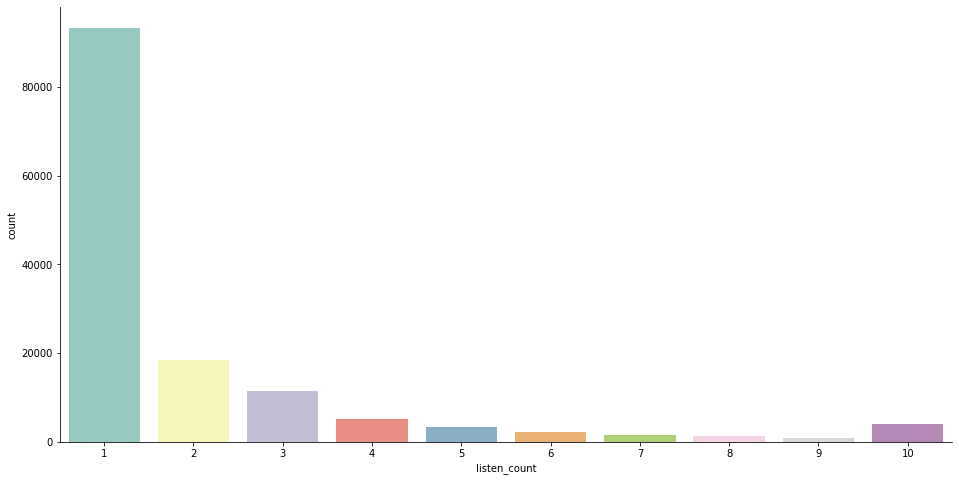

In [ ]:
plt.figure(figsize=(16, 8))
sns.barplot(x='listen_count', y='count', palette='Set3', data=listen_counts)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [ ]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_song_reduced[['user_id', 'song_id', 'listen_count']], reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=.25)

**Implementing SVD using Grid Sreach Cross Validation**

***SVD Hyper Parameters :***
- n_factors – The number of factors. Default is 100.
- n_epochs – The number of iteration of the SGD procedure. Default is 20.
- lr_all – The learning rate for all parameters. Default is 0.005.
- reg_all – The regularization term for all parameters. Default is 0.02.

In [ ]:
#Using Grid Sreach Cross Validation
param_grid = {'n_factors': [160],    
              'n_epochs': [100], 
              'lr_all': [0.001, 0.005],
              'reg_all': [0.08, 0.1]}

In [ ]:
grid_search_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, joblib_verbose=4, n_jobs=-2)

In [ ]:
# find the best parameters for the model
grid_search_svd.fit(data)
find_algo = grid_search_svd.best_estimator['rmse']
print(grid_search_svd.best_score['rmse'])
print(grid_search_svd.best_params['rmse'])

[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   40.6s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s


1.8414060389648916
{'n_factors': 160, 'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.1}


[Parallel(n_jobs=-2)]: Done  12 out of  12 | elapsed:  8.0min finished


In [ ]:
# Perform the cross validation
cross_validate(find_algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8521  1.7982  1.8012  1.8308  1.8353  1.8235  0.0207  
Fit time          47.14   47.48   47.12   47.49   47.01   47.25   0.20    
Test time         0.47    0.44    0.44    0.28    0.26    0.38    0.09    


{'fit_time': (47.138073205947876,
  47.47591471672058,
  47.12320399284363,
  47.49169182777405,
  47.01172757148743),
 'test_rmse': array([1.85210077, 1.79820114, 1.80116247, 1.83076866, 1.83527283]),
 'test_time': (0.46530652046203613,
  0.44085121154785156,
  0.4414863586425781,
  0.2789268493652344,
  0.2585732936859131)}

In [ ]:
final_algorithm = SVD(n_factors=160, n_epochs=100, lr_all=0.005, reg_all=0.1)
final_algorithm.fit(trainset)
test_predictions = final_algorithm.test(testset)
print(f"The RMSE is {accuracy.rmse(test_predictions, verbose=True)}")

RMSE: 1.8380
The RMSE is 1.837960040470629


In [ ]:
test_predictions[1:20]

[Prediction(uid='bbc269796a0c63bcfd839ec1fd3cc58a173a4514', iid='SOEWYLX12A6D4F8E5F', r_ui=1.0, est=1.635922726696709, details={'was_impossible': False}),
 Prediction(uid='6ce8e80c1f1d6d6af84701e20f70b01fb14650b7', iid='SOQBMFK12A8C13835B', r_ui=1.0, est=1.832561812017305, details={'was_impossible': False}),
 Prediction(uid='8f84fa34b5c18c333574cdb6b83c2cb7c616ae26', iid='SOZVVRE12A8C143150', r_ui=2.0, est=2.818085064128581, details={'was_impossible': False}),
 Prediction(uid='bb25adc62bedda82437af1fbe61cfad84ccc69a5', iid='SOPVQLJ12A67AE2281', r_ui=1.0, est=1.2582349168095917, details={'was_impossible': False}),
 Prediction(uid='0d396cbde5e186bc7ae0fdef0c534ed1d7e3c10d', iid='SORWLTW12A670208FA', r_ui=2.0, est=1.827083964768485, details={'was_impossible': False}),
 Prediction(uid='a13426cb3346fd5c90916befb93fd67c3a530e21', iid='SOAFQGA12A8C1367FA', r_ui=1.0, est=1.7714526463085676, details={'was_impossible': False}),
 Prediction(uid='e59e213333a7f5fdcefbce23f041bbe113c5e868', iid='SOH

 # <center> **The End**